# Load torch device

In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW

# --- this part is required for mac --- #
import sys, os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# comment out if youre on windows and remove 'src.' prefixes from imports #

from Datasets.batching import BatchManager

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Choose NCars or NCaltech-101 Dataset

In [ ]:
from Datasets.ncaltech101 import NCaltech
from Datasets.ncars import NCars

# options: 'ncars' or 'ncaltech'
#dataset = 'ncars'  
#dataset = 'ncaltech'

if dataset == 'ncars':
    num_classes = len(NCars.get_info().classes)
    image_size: tuple[int, int] = NCars.get_info().image_size  # (height=240, width=180)
if dataset == 'ncaltech':
    num_classes = len(NCaltech.get_info().classes)
    image_size: tuple[int, int] = NCaltech.get_info().image_size  # (height=240, width=180)

# Model Initialization

In [3]:
from Models.CleanAEGNN.GraphRes import GraphRes as AEGNN
from torch_geometric.data import Data as PyGData
from Datasets.ncaltech101 import NCaltech
from Datasets.ncars import NCars

input_shape: tuple[int, int, int] = (*image_size, 3)

aegnn = AEGNN(
    input_shape = input_shape,
    kernel_size = 8,
    n = [1, 16, 32, 32, 32, 128, 128, 128],
    pooling_outputs = 128,
    num_outputs = num_classes,
).to(device)

def transform_graph(graph: PyGData) -> PyGData:
    graph = aegnn.data_transform(
        graph, n_samples = 25000, sampling = True,
        beta =  0.5e-5, radius = 5.0,
        max_neighbors = 32
    ).to(device)
    return graph

# Dataset Initialization and processing (from the parsed dataset from the aegnn issues thread)

In [4]:
#Instantiating the ncaltech dataset
if dataset == 'ncaltech':
    dataset_obj = NCaltech(
        #root=r"C:\Users\hanne\Documents\Hannes\Uni\Maastricht\Project\Datasets",
        root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/N-Caltech101',
        transform=transform_graph
    )
if dataset == 'ncars':
    dataset_obj = NCars(
        #root=r"C:\Users\hanne\Documents\Hannes\Uni\Maastricht\Project\Datasets",
        root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/Prophesee_Dataset_n_cars',
        transform=transform_graph
)

# Processing the training part of the dataset
dataset_obj.process(modes = ["training"])

Display example events data point

In [5]:
training_set = BatchManager(
    dataset=dataset_obj,
    batch_size=8,
    mode="training"
)

In [6]:
optimizer = Adam(aegnn.parameters(), lr=5e-3)
loss_fn = CrossEntropyLoss()

classes = dataset_obj.get_info().classes

cls_to_idx = dict(zip(classes, range(len(classes))))

In [7]:
def label_to_index(lbl):
    if isinstance(lbl,str): # for n-caltech labels (strings)
        return cls_to_idx[lbl]
    if isinstance(lbl, torch.Tensor): # for ncars labels (tensors)
        return int(lbl.item())  

In [ ]:
aegnn.train()

losses = []
for i in range(50):
    examples = next(training_set)
    reference = torch.tensor([label_to_index(lbl) for lbl in examples.label], dtype=torch.long).to(device)
    out = aegnn(examples)
    loss = loss_fn(out, reference)
    loss.backward()
    optimizer.step()
    print(f"Iteration {i} loss: {loss.item()}")
    losses.append(loss.item())

    optimizer.zero_grad()

torch.save(aegnn.state_dict(), f"aegnn_{dataset}.pth")

/Users/mielgeraats/miniconda3/envs/GNNBenchmark/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: We do not recommend using the non-optimized CPU version of `SplineConv`. If possible, please move your data to GPU.
  return forward_call(*args, **kwargs)


Iteration 0 loss: 0.6931471824645996
Iteration 1 loss: 0.692560613155365
Iteration 2 loss: 0.6943913698196411
Iteration 3 loss: 0.7000166773796082
Iteration 4 loss: 0.7033820152282715
Iteration 5 loss: 0.6964921355247498
Iteration 6 loss: 0.6955149173736572
Iteration 7 loss: 0.6951823830604553
Iteration 8 loss: 0.6951984763145447
Iteration 9 loss: 0.6871793270111084
Iteration 10 loss: 0.694893479347229
Iteration 11 loss: 0.6973429918289185
Iteration 12 loss: 0.6819410920143127
Iteration 13 loss: 0.698064923286438
Iteration 14 loss: 0.7027807235717773
Iteration 15 loss: 0.6770902276039124
Iteration 16 loss: 0.701363205909729
Iteration 17 loss: 0.6886449456214905
Iteration 18 loss: 0.6910721063613892
Iteration 19 loss: 0.6820716261863708
Iteration 20 loss: 0.7131513953208923
Iteration 21 loss: 0.658446729183197
Iteration 22 loss: 0.6881401538848877
Iteration 23 loss: 0.690918505191803
Iteration 24 loss: 0.7175239324569702
Iteration 25 loss: 0.7096379399299622
Iteration 26 loss: 0.6860681

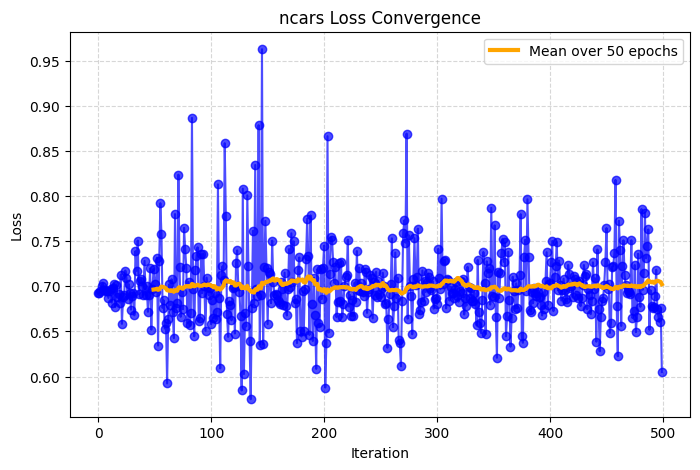

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_convergence(loss_list, window=50, title=f"ncars Loss Convergence", xlabel="Iteration", ylabel="Loss"):
    """
    Plots the loss over iterations to visualize convergence.

    Parameters:
    - loss_list: List or array of loss values over iterations
    - title: Plot title
    - xlabel: X-axis label
    - ylabel: Y-axis label
    """
    plt.figure(figsize=(8,5))
    plt.plot(loss_list, marker='o', linestyle='-', color='blue', alpha=0.7)
    moving_mean = np.convolve(loss_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_list)), moving_mean, color='orange', linewidth=3, label=f'Mean over {window} epochs')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

plot_loss_convergence(losses)

In [10]:
aegnn.eval()
predictions_made = 0
correct = 0
with torch.no_grad():
    for i in range(50):
        examples = next(training_set)
        reference = torch.tensor([label_to_index(lbl) for lbl in examples.label], dtype=torch.long).to(device)
        out = aegnn(examples)
        prediction = out.argmax(dim = -1)
        is_correct = prediction - reference
        is_correct = is_correct[is_correct == 0]
        correct += is_correct.shape[0]
        predictions_made += prediction.shape[0]

        print(f"Accuracy: {correct / predictions_made}")

print(f"Accuracy: {correct / predictions_made}")

/Users/mielgeraats/miniconda3/envs/GNNBenchmark/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: We do not recommend using the non-optimized CPU version of `SplineConv`. If possible, please move your data to GPU.
  return forward_call(*args, **kwargs)


Accuracy: 0.75
Accuracy: 0.75
Accuracy: 0.625
Accuracy: 0.625
Accuracy: 0.6
Accuracy: 0.5625
Accuracy: 0.5357142857142857
Accuracy: 0.53125
Accuracy: 0.5416666666666666
Accuracy: 0.525
Accuracy: 0.5340909090909091
Accuracy: 0.5416666666666666
Accuracy: 0.5288461538461539
Accuracy: 0.5267857142857143
Accuracy: 0.5333333333333333
Accuracy: 0.5234375
Accuracy: 0.5294117647058824
Accuracy: 0.5069444444444444
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.5119047619047619
Accuracy: 0.5170454545454546
Accuracy: 0.5163043478260869
Accuracy: 0.5104166666666666
Accuracy: 0.525
Accuracy: 0.5096153846153846
Accuracy: 0.5092592592592593
Accuracy: 0.5133928571428571
Accuracy: 0.5129310344827587
Accuracy: 0.5041666666666667
Accuracy: 0.5080645161290323
Accuracy: 0.51171875
Accuracy: 0.5
Accuracy: 0.5036764705882353
Accuracy: 0.5035714285714286
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.4967105263157895
Accuracy: 0.5
Accuracy: 0.503125
Accuracy: 0.5030487804878049
Accuracy: 0.5089285714285714
Accuracy: 0.51453